# Import libraries (Pipeline, EDA, data processing)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time
from datetime import datetime, timedelta, date

from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.filters import default_us_equity_universe_mask
from quantopian.pipeline.data import Fundamentals


# Import libraries (preprocessing, machine learning, valuation)

In [2]:

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB




# Set parameters 

In [3]:
MIN_PRICE = 2.0
MAX_PRICE = 1000.0
MIN_MARKET_CAP = 25000000

FIRST_PERIOD = 0
PERIODS_NUM = 8

MISSING_RATE_COL = 0.8
MISSING_RATE_ROW = 0.8
PCA_THRESHOLD = 0.8

CV_FOLDS = 5 
CV_RANDOM_STATE = 1 

LOSS_VECTOR = [3, 1, 0, -1, -3]

BASE_EQUITY = 100000
ASSET_NUMBER = 50


# Create Pipeline

In [4]:


MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcabike camera mountre',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

as_ = morningstar.asset_classification
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_ratios
v = morningstar.valuation
vr = morningstar.valuation_ratios

def make_pipeline():
    
    #universe = QTradableStocksUS()
    universe = (default_us_equity_universe_mask(minimum_market_cap= MIN_MARKET_CAP)) & \
        (USEquityPricing.open.latest > MIN_PRICE) & (USEquityPricing.open.latest < MAX_PRICE) 

    price = USEquityPricing.open.latest
    volume = USEquityPricing.volume.latest
    
    # Morningstar ratios
    growth_score = as_.growth_score.latest
    value_score = as_.value_score.latest
    
    # Valuation ratios
    market_cap = v.market_cap.latest/1000000
    cash_return = vr.cash_return.latest
    cf_yield = vr.cf_yield.latest
    earning_yield = vr.earning_yield.latest
    ev_to_ebitda = vr.ev_to_ebitda.latest
    pb_ratio = vr.pb_ratio.latest
    pe_ratio = vr.pe_ratio.latest
    peg_ratio = vr.peg_ratio.latest
    ps_ratio = vr.ps_ratio.latest
    pcf_ratio = vr.pcf_ratio.latest
    total_yield = vr.total_yield.latest

    # Operation ratios
    ltbe_ratio = or_.long_term_debt_equity_ratio.latest
    current_ratio = or_.current_ratio.latest
    interest_coverage = or_.interest_coverage.latest
    assets_turnover = or_.assets_turnover.latest
    cash_conversion_cycle = or_.cash_conversion_cycle.latest
    days_in_sales = or_.days_in_sales.latest
    net_income_growth = or_.net_income_growth.latest
    sales_per_employee = or_.sales_per_employee.latest
    revenue_growth = or_.revenue_growth.latest
    dps_growth = er.dps_growth.latest
    
    # Margins
    ebit_margin = or_.ebit_margin.latest
    gross_margin = or_.gross_margin.latest
    operation_margin = or_.operation_margin.latest
    net_margin = or_.net_margin.latest

    # Returns
    roa = or_.roa.latest
    roe = or_.roe.latest
    roic = or_.roic.latest
    
    # Momentum   
    class mom_1 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=126)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-1] - prices[-252])/prices[-252] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_2 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=63)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-126])/prices[-126] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    class mom_3 (CustomFactor):
        """ Momentum factor """
        inputs = [USEquityPricing.close,
                  Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, prices, returns):
            out[:] = ((prices[-21] - prices[-63])/prices[-63] -
                      (prices[-1] - prices[-21])/prices[-21]) / np.nanstd(returns, axis=0)
    
    mom_test_1 = mom_1(mask = universe)
    mom_test_2 = mom_2(mask = universe)
    mom_test_3 = mom_3(mask = universe)
    
    price_mom_M = Returns(window_length=21)
    price_mom_Q = Returns(window_length=63)
    price_mom_H = Returns(window_length=126)
    price_mom_Y = Returns(window_length=252)
 
    # Create Pipeline
    pipe = Pipeline(columns = {"roa" : roa,
                               "roe":roe,
                               "roic" : roic,
                               "operation_margin" : operation_margin,
                               "ebit_margin" : ebit_margin,
                               "gross_margin" : gross_margin,
                               "net_margin" : net_margin,
                               "ltbe_ratio" : ltbe_ratio,
                               "current_ratio" : current_ratio,
                               "interest_coverage" : interest_coverage,
                               "assets_turnover" : assets_turnover,
                               "cash_conversion_cycle" : cash_conversion_cycle,
                               "days_in_sales" : days_in_sales,
                               "net_income_growth" : net_income_growth,
                               "sales_per_employee" : sales_per_employee,
                               "revenue_growth" : revenue_growth,
                               "dps_growth" : dps_growth,
                               "market_cap": market_cap,
                               "cash_return" : cash_return,
                               "cf_yield" : cf_yield,
                               "earning_yield" : earning_yield,
                               "ev_to_ebitda" : ev_to_ebitda,
                               "pb_ratio": pb_ratio,
                               "pe_ratio": pe_ratio,
                               "ps_ratio" : ps_ratio,
                               "pcf_ratio": pcf_ratio,
                               "total_yield" : total_yield,
                               "value_score" :value_score,
                               "growth_score" :growth_score,
                               "mom_test_1" : mom_test_1,
                               "mom_test_2" : mom_test_2,
                               "mom_test_3" : mom_test_3,
                               "price_mom_M" : price_mom_M,
                               "price_mom_Q" : price_mom_Q,
                               "price_mom_H" : price_mom_H,
                               "price_mom_Y" : price_mom_Y,
                               
                               "price": price,
                               "volume": volume
                              },
                   screen = universe)
    return pipe
    
    


# Define functions (time_intervals, get_assets)

In [5]:

def time_intervals(start_year, month, day):            
    years = date.today().year+1-start_year
    dates = pd.date_range(date(start_year, month=month, day=1), periods=years*4, freq='3MS')        
    dates = [date(d.date().year, d.date().month, day)  for d in dates if d.date() < date.today()]
    return dates


def get_assets(f_date, i):
    start_timer = time()

    results = run_pipeline(make_pipeline(), start_date = f_date, end_date= f_date)
    
    end_timer = time()
    print i, f_date, "Time to run pipeline %.2f secs" % (end_timer - start_timer)
    results = results[~results.index.duplicated(keep='first')]      
    results = results.loc[ results.index.get_level_values(0)[0] ]   
    return results
    

# Load universe

In [6]:

START = date(2005, 1, 1)

QUARTERS = time_intervals(START.year, START.month, START.day)

def load_universe():    
    universe = []
    for i in range(len(QUARTERS)):    
        current_date = QUARTERS[i]   
        df = get_assets(current_date, i)
        universe.append(df)
    return universe

UNIVERSE = load_universe()


/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


0 2005-01-01 Time to run pipeline 17.91 secs
1 2005-04-01 Time to run pipeline 8.17 secs
2 2005-07-01 Time to run pipeline 7.82 secs
3 2005-10-01 Time to run pipeline 7.66 secs
4 2006-01-01 Time to run pipeline 7.51 secs
5 2006-04-01 Time to run pipeline 7.31 secs
6 2006-07-01 Time to run pipeline 8.17 secs
7 2006-10-01 Time to run pipeline 7.68 secs
8 2007-01-01 Time to run pipeline 7.53 secs
9 2007-04-01 Time to run pipeline 7.38 secs
10 2007-07-01 Time to run pipeline 8.65 secs
11 2007-10-01 Time to run pipeline 7.23 secs
12 2008-01-01 Time to run pipeline 7.53 secs
13 2008-04-01 Time to run pipeline 7.76 secs
14 2008-07-01 Time to run pipeline 8.55 secs
15 2008-10-01 Time to run pipeline 7.66 secs
16 2009-01-01 Time to run pipeline 7.86 secs
17 2009-04-01 Time to run pipeline 7.88 secs
18 2009-07-01 Time to run pipeline 7.98 secs
19 2009-10-01 Time to run pipeline 7.33 secs
20 2010-01-01 Time to run pipeline 8.16 secs
21 2010-04-01 Time to run pipeline 7.45 secs
22 2010-07-01 Time 

In [7]:
print "number of periods:", len(UNIVERSE)


number of periods: 58


#Loss function

In [8]:
def loss_func (cm):
    loss_value = (cm[0,0]*LOSS_VECTOR [0] + cm[1,1]*LOSS_VECTOR[1] + cm[2,2]*LOSS_VECTOR[0]  +
                 cm[0,1]*LOSS_VECTOR [2] + cm[0,2]*LOSS_VECTOR[4] + 
                 cm[1,0]*LOSS_VECTOR [3] + cm[1,2]*LOSS_VECTOR[3] +
                 cm[2,0]*LOSS_VECTOR [4] + cm[2,1]*LOSS_VECTOR[3])
    return loss_value



# Put together results

In [9]:

def index_of_t(first_period, t):
    return (first_period + PERIODS_NUM - 1) - t

def assemble_dataframe(first_period):
    results = UNIVERSE[index_of_t(first_period, 0)]
    for t in range(1, PERIODS_NUM):        
        results = results.join(UNIVERSE[index_of_t(first_period, t)], rsuffix='_%d' % t, how='outer')    

    return results

# Get future prices

In [10]:

def get_future_prices(first_period):        
    future_price = UNIVERSE[index_of_t(first_period, -1)]['price']    
    future_price = pd.DataFrame(future_price)
    future_price.rename(columns = {0:"price"}, inplace= True) 
    future_price.drop(future_price[future_price['price'].isnull()].index, inplace=True)
    return future_price


# Handle missing data 

In [11]:
def column_of_t(name, t):
    if t == 0:
        return name
    else:
        return name+'_%d' % t
    
def columns_of(name):
    names = []
    for i in range(PERIODS_NUM):
        names.append(column_of_t(name, i))
    return names

def clean_dataframe(df):
    print "cleaning data..."
    print df.isnull().sum().sum()
    start_timer = time()
    df.drop(df[df['price'].isnull()].index, inplace=True)
    
    threshold = len(df) * MISSING_RATE_COL
    df.dropna(thresh = threshold, axis = 1, inplace = True)
    
    threshold = len(df.columns) * MISSING_RATE_ROW
    df.dropna(thresh = threshold, axis = 0, inplace= True)
    
    print df.isnull().sum().sum()
            
    for column in UNIVERSE[0].columns:
        current_columns = columns_of(column)
        existing_columns = df.columns & set(current_columns)
        
        df[existing_columns] = df[existing_columns].fillna(method='bfill', axis=1)
        df[existing_columns] = df[existing_columns].fillna(method='ffill', axis=1)
        
        for ec in existing_columns:
            df[ec] = df[ec].fillna(df[ec].mean())
                
    print df.isnull().sum().sum()
        
    end_timer = time()
    print "Time to clean: %.2f secs" % (end_timer - start_timer)
    return df


# Compute target variable

In [12]:
def compute_target(fundamentals, future_prices):
    target = (future_prices["price"] - fundamentals["price"]) / fundamentals["price"]
    target = target.rank()
    target = target.apply(lambda x: 
                        "Top" if x > len(target)*2/3 
                        else "Mid" if x >= len(target)*1/3
                        else "Bot")
    return target

# Preparing Machine Learning


## Standardisation

In [13]:
def standardize(df_X):
    names = df_X.columns
    index = df_X.index
    scaler = preprocessing.StandardScaler()
    df_X = scaler.fit_transform(df_X)
    df_X = pd.DataFrame(df_X, index=index, columns=names)
    return df_X

## PCA - number of components and compression

In [14]:

TRAINING_N_PCA = None

def training_pca(df_X):    
    global TRAINING_N_PCA
    explained_var = []

    for n_components in range(len(df_X.columns)):
        pca = PCA(n_components=n_components)        
        pca.fit_transform(df_X)
        explain = sum(pca.explained_variance_ratio_)
        explained_var.append(explain)

    n_pca = 1

    for i in range (len (explained_var)):
        if explained_var [i] < PCA_THRESHOLD:
            n_pca  +=1
    
    TRAINING_N_PCA = n_pca
    pca = PCA(n_components = n_pca)
    principalDf = pd.DataFrame(pca.fit_transform(df_X), index=df_X.index)
    
    print "Number of PC-s. ", n_pca
    print "Variance explained by PCA: ", sum(pca.explained_variance_ratio_)
    
    return principalDf

def prediction_pca(df_X):
    pca = PCA(n_components = TRAINING_N_PCA)
    principalDf = pd.DataFrame(pca.fit_transform(df_X), index=df_X.index)
    return principalDf


## Data preparation

In [15]:
def prepare_data(index):
    fundamentals = assemble_dataframe(index)
    fundamentals = clean_dataframe(fundamentals)
    
    future_prices = get_future_prices(index)
    print 'fundamentals:', len(fundamentals), 'rows, future prices:', len(future_prices), 'rows'
    common_assets = (fundamentals.index & future_prices.index)
    fundamentals = fundamentals.loc[common_assets]
    future_prices = future_prices.loc[common_assets]
    print 'Lenght of common section:', len(common_assets)
    target = compute_target(fundamentals, future_prices)      
    return fundamentals, target, future_prices
    

## Training data and validation data

In [16]:
def training_data(index):
    global X_train, X_val, y_train, y_val
    fundamentals, target, _future_price = prepare_data(index)
    df_X = standardize(fundamentals)  
    principalDf = training_pca(df_X)
    X_train, X_val, y_train, y_val = train_test_split(principalDf, target, test_size=0.2, random_state=CV_RANDOM_STATE)


## Prediction data 

In [17]:
def prediction_data(index):
    fundamentals, _target, future_prices = prepare_data(index+1)
    prices = pd.DataFrame({'price': fundamentals['price'], 'future_price': future_prices['price']}, index=fundamentals.index)    
    df_X = standardize(fundamentals) 
    principalDf = prediction_pca(df_X)
    return principalDf, prices
    

# Model Selection - GridSearch

## K-nearest neighbors - KNN

In [18]:
def knn():
    print "KNN"
    start_timer = time()
    
    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)
    
    classifier = KNeighborsClassifier()  

    grid_param = {  
        'n_neighbors': [25,39, 55],
        'weights': ['uniform', "distance"],
        'algorithm': ["ball_tree", "kd_tree", "auto"]
    }

    knn_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    knn_grid.fit(X_train, y_train)  

    knn_val = knn_grid.predict(X_val)
    knn_cm = confusion_matrix(y_val, knn_val)
    knn_cr = classification_report(y_val, knn_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    
    return {"model": knn_grid, "name": "KNN", "value": loss_func(knn_cm)}


## Random forest - RFC

In [19]:
def rfc():
    print "Random forest"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)    
    classifier = RandomForestClassifier()  

    grid_param = {  
        'n_estimators': [10, 100, 1000],
        'criterion': ['gini'],
        'bootstrap': [True, False]
    }

    rfc_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    rfc_grid.fit(X_train, y_train)   

    rfc_val = rfc_grid.predict(X_val)
    rfc_cm = confusion_matrix(y_val, rfc_val)
    rfc_cr = classification_report(y_val, rfc_val)
    
    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": rfc_grid, "name": "RFC", "value": loss_func(rfc_cm)}



## Support vector classifier - SVC

In [20]:
def svc():
    print "SVC"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)    
    classifier = SVC(probability=True)  

    grid_param = {  
        'C': [ 0.1, 1],
        'kernel': ['rbf', "linear"]
    }

    svc_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    svc_grid.fit(X_train, y_train)  

    svc_val = svc_grid.predict(X_val)
    svc_cm = confusion_matrix(y_val, svc_val)
    svc_cr = classification_report(y_val, svc_val)
   
    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": svc_grid, "name": "SVC", "value": loss_func(svc_cm)}


## Logistic regression model - LGM

In [21]:
def lgm():
    print "LGM"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)    
    classifier = LogisticRegression()  

    grid_param = {  
        'penalty': ['l1', "l2"],
        'C': [0.01, 0.1, 1],
        'solver': ['newton-cg', 'lbfgs', "liblinear"],
        'verbose': [1]
    }

    lgm_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    lgm_grid.fit(X_train, y_train)  

    lgm_val = lgm_grid.predict(X_val)
    lgm_cm = confusion_matrix(y_val, lgm_val)
    lgm_cr = classification_report(y_val, lgm_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": lgm_grid, "name": "LGM", "value": loss_func(lgm_cm)}


# Gradient boosting model - GBM

In [22]:
def gbm():
    print "GBM"
    start_timer = time()

    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE) 
    
    classifier = GradientBoostingClassifier()  

    grid_param = {  
        'loss': ['deviance'],
        'learning_rate': [0.001, 0.01],
        'n_estimators': [100, 1000],
        'max_depth': [1, 3],
        'max_features':['auto']
    }

    gbm_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    gbm_grid.fit(X_train, y_train)  

    gbm_val = gbm_grid.predict(X_val)
    gbm_cm = confusion_matrix(y_val, gbm_val)
    gbm_cr = classification_report(y_val, gbm_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": gbm_grid, "name": "GBM", "value": loss_func(gbm_cm)}

# Gaussian naive bayes - GNB

In [23]:
def gnb():
    print "GNB"
    start_timer = time()
    
    skf = StratifiedKFold (y_train, n_folds=CV_FOLDS, random_state=CV_RANDOM_STATE)
    
    classifier =  GaussianNB ()

    grid_param = {  
       }

    gnb_grid = GridSearchCV(estimator=classifier,  
                         param_grid=grid_param,
                         scoring='accuracy',
                         cv=skf,
                         n_jobs=-1)

    gnb_grid.fit(X_train, y_train)
    
    gnb_val = gnb_grid.predict(X_val)
    gnb_cm = confusion_matrix(y_val, gnb_val)
    gnb_cr = classification_report(y_val, gnb_val)

    end_timer = time()
    print "Time to create model %.2f secs" % (end_timer - start_timer)
    return {"model": gnb_grid, "name": "GNB", "value": loss_func(gnb_cm)}

## Select best model

In [24]:
def select():
    global loss_models
    loss_models = [
        knn(),
        svc(),
        lgm(), 
        rfc(),
        gbm(),
        gnb()
    ]
    print "Losses", map(lambda f: (f["name"], f["value"]), loss_models)
    return sorted(loss_models, key = lambda i: i["value"], reverse=True)[0]

## Buy list and Sell list

In [25]:
def buy(buy_list, prices, equity):
    equity_per_share = equity / len(buy_list)
    b = pd.DataFrame({'equity': equity_per_share}, index=buy_list)
    b = b.join(prices['price'])
    b = b.join(prices['future_price'])
    b['shares'] = (b['equity'] / b['price']).round() - 1  
    b['revenue'] = b['shares'] * b['future_price']
    b['profit'] = b['revenue'] - b['equity']
    return b 


def sell(sell_list, prices, equity):    
    equity_per_share = equity / len(sell_list)
    s = pd.DataFrame({'equity': equity_per_share}, index=sell_list)
    s = s.join(prices['price'])
    s = s.join(prices['future_price'])
    s['shares'] = (s['equity'] / s['price']).round() - 1  
    s['revenue'] = s['shares'] * s['future_price']
    s['profit'] = s['equity'] - s['revenue']
    return s 


# Run the whole process

In [28]:

def run():  
    
    start_timer = time()

    global equity_array, equity, equity_array_long_short, equity_long_short, equity_array_long, \
                equity_long, equity_array_short, equity_short
    global long_short_assets_buys, long_short_assets_sells, long_assets, short_assets
    
    long_short_assets_buys = []
    long_short_assets_sells = []
    long_assets = []
    short_assets = []    
    
    equity = BASE_EQUITY
    equity_array = [equity]
    
    equity_long_short = BASE_EQUITY
    equity_array_long_short = [equity]
    
    equity_long = BASE_EQUITY
    equity_array_long = [equity]
    
    equity_short = BASE_EQUITY
    equity_array_short = [equity]
    
    for i in range(FIRST_PERIOD, len(UNIVERSE)-PERIODS_NUM-1):    #len(UNIVERSE)-PERIODS_NUM-1):     
        print i, "run"
        training_data(i)
        best = select()
        print "best model: ", best["name"], best["value"]
        best_model = best["model"]
    
        next_dataset, next_prices = prediction_data(i)
        
        predictions = pd.DataFrame(best_model.predict_proba(next_dataset), index=next_dataset.index, columns=best_model.best_estimator_.classes_)
        
        buy_list = predictions['Top'].sort_values(ascending=False)[:ASSET_NUMBER].index
        
        sell_list = predictions['Bot'].sort_values(ascending=False)[:ASSET_NUMBER].index
        
        print ""
        buys = buy(buy_list, next_prices, equity_long_short)
        sells = sell(sell_list, next_prices, equity_long_short)        
        long_short_assets_buys.append(buys)
        long_short_assets_sells.append(sells)
        
        long_short_profit = buys['profit'].sum() + sells['profit'].sum()
        equity_long_short += long_short_profit
        equity_array_long_short.append(equity_long_short)
        print "LONG_SHORT Profit: ", long_short_profit, "Equity: ", equity_long_short


        print ""
        buys = buy(buy_list, next_prices, equity_long)
        long_assets.append(buys)
        
        long_only = buys['profit'].sum()        
        equity_long += long_only
        equity_array_long.append(equity_long)
        print "LONG_Only Profit :", long_only, "Equity: ", equity_long
        
        
        print ""
        sells = sell(sell_list, next_prices, equity_short)
        short_assets.append(sells)
        
        short_only = sells['profit'].sum()
        equity_short += short_only
        equity_array_short.append(equity_short)        
        print "SHORT_Only Profit :", short_only, "Equity: ", equity_short
        
        print ""
        end_timer = time()
        print "Time needed to run %.2f secs" % (end_timer - start_timer)

        print "*******************************"
        
        if equity_long_short < 0:
            print "GAME OVER!"
            break

In [29]:
run()

0 run
cleaning data...
380456
15787
0
Time to clean: 0.28 secs
fundamentals: 3318 rows, future prices: 4005 rows
Lenght of common section: 3233
Number of PC-s.  38
Variance explained by PCA:  0.807937653189
KNN
Time to create model 8.91 secs
SVC
Time to create model 87.01 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 19.16 secs
Random forest
Time to create model 146.29 secs
GBM
Time to create model 156.29 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', 64), ('SVC', 35), ('LGM', -23), ('RFC', 117), ('GBM', 41), ('GNB', 11)]
best model:  RFC 117
cleaning data...
387678
15452
0
Time to clean: 0.24 secs
fundamentals: 3329 rows, future prices: 3951 rows
Lenght of 

0
Time to clean: 0.29 secs
fundamentals: 3174 rows, future prices: 3596 rows
Lenght of common section: 3061

LONG_SHORT Profit:  20481.2441881 Equity:  123717.311665

LONG_Only Profit : 5835.30563179 Equity:  83020.0856318

SHORT_Only Profit : 15307.2372183 Equity:  145792.140437

Time needed to run 3287.58 secs
*******************************
7 run
cleaning data...
394711
16250
0
Time to clean: 0.29 secs
fundamentals: 3174 rows, future prices: 3596 rows
Lenght of common section: 3061
Number of PC-s.  41
Variance explained by PCA:  0.809054310965
KNN
Time to create model 9.67 secs
SVC
Time to create model 90.07 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 20.96 secs
Random for

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 13.87 secs
Random forest
Time to create model 139.08 secs
GBM
Time to create model 149.21 secs
GNB
Time to create model 0.06 secs
Losses [('KNN', 134), ('SVC', 180), ('LGM', 110), ('RFC', 159), ('GBM', 75), ('GNB', -41)]
best model:  SVC 180
cleaning data...
311988
14666
0
Time to clean: 0.28 secs
fundamentals: 2927 rows, future prices: 3529 rows
Lenght of common section: 2881

LONG_SHORT Profit:  8757.88643513 Equity:  203320.363514

LONG_Only Profit : -8798.032 Equity:  105499.429

SHORT_Only Profit : 15723.4354689 Equity:  143647.020632

Time needed to run 6356.39 secs
*******************************
14 run
cleaning data...
311


LONG_SHORT Profit:  11631.028 Equity:  194737.006614

LONG_Only Profit : 10440.384 Equity:  104426.984

SHORT_Only Profit : -5771.0675084 Equity:  126975.084983

Time needed to run 8983.98 secs
*******************************
20 run
cleaning data...
257642
17264
0
Time to clean: 0.28 secs
fundamentals: 2957 rows, future prices: 3455 rows
Lenght of common section: 2895
Number of PC-s.  48
Variance explained by PCA:  0.810794683327
KNN
Time to create model 8.12 secs
SVC
Time to create model 81.72 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 11.96 secs
Random forest
Time to create model 129.14 secs
GBM
Time to create model 139.00 secs
GNB
Time to create model 0.04 sec

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 18.33 secs
Random forest
Time to create model 132.69 secs
GBM
Time to create model 136.41 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', 55), ('SVC', 67), ('LGM', 81), ('RFC', 147), ('GBM', 112), ('GNB', 43)]
best model:  RFC 147
cleaning data...
249540
13826
0
Time to clean: 0.27 secs
fundamentals: 3035 rows, future prices: 3680 rows
Lenght of common section: 2992

LONG_SHORT Profit:  -3685.592 Equity:  191336.551683

LONG_Only Profit : 8009.02 Equity:  134531.5

SHORT_Only Profit : -8083.90707484 Equity:  95901.0798503

Time needed to run 11918.53 secs
*******************************
27 run
cleaning data...
249540
13826
0
Time to 


LONG_SHORT Profit:  22165.2957959 Equity:  212013.850417

LONG_Only Profit : 2769.88909847 Equity:  142970.939098

SHORT_Only Profit : 9075.51949755 Equity:  100828.164995

Time needed to run 14397.41 secs
*******************************
33 run
cleaning data...
292981
12671
0
Time to clean: 0.25 secs
fundamentals: 3141 rows, future prices: 3798 rows
Lenght of common section: 3055
Number of PC-s.  38
Variance explained by PCA:  0.808770109359
KNN
Time to create model 8.26 secs
SVC
Time to create model 75.41 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 15.98 secs
Random forest
Time to create model 132.08 secs
GBM
Time to create model 150.81 secs
GNB
Time to create model 0.04 se

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 14.82 secs
Random forest
Time to create model 117.96 secs
GBM
Time to create model 139.03 secs
GNB
Time to create model 0.04 secs
Losses [('KNN', 212), ('SVC', 186), ('LGM', 179), ('RFC', 178), ('GBM', 156), ('GNB', -75)]
best model:  KNN 212
cleaning data...
289047
16882
0
Time to clean: 0.24 secs
fundamentals: 3103 rows, future prices: 3670 rows
Lenght of common section: 3020

LONG_SHORT Profit:  -33807.172 Equity:  189871.301034

LONG_Only Profit : -14800.74 Equity:  112185.4

SHORT_Only Profit : -5607.88587794 Equity:  111220.108244

Time needed to run 17299.66 secs
*******************************
40 run
cleaning data...
28904

LONG_SHORT Profit:  -8987.29 Equity:  187784.137807

LONG_Only Profit : 9063.36267739 Equity:  137388.03

SHORT_Only Profit : -7576.38718834 Equity:  96256.1556233

Time needed to run 19784.20 secs
*******************************
46 run
cleaning data...
308812
11793
0
Time to clean: 0.24 secs
fundamentals: 3037 rows, future prices: 3736 rows
Lenght of common section: 2971
Number of PC-s.  40
Variance explained by PCA:  0.811104971065
KNN
Time to create model 6.85 secs
SVC
Time to create model 76.05 secs
LGM
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Time to create model 12.02 secs
Random forest
Time to create model 134.20 secs
GBM
Time to create model 149.65 secs
GNB
Time to create model 0.04 secs
Losses

## Calculate CAGR

In [30]:
def CAGR ():    
    
    start_cap = profit_table["Long_Shorts"].loc[0]
    Long_Shorts_end = profit_table["Long_Shorts"].iloc[-1]
    CAGR_Long_Shorts = (((Long_Shorts_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_Long_Shorts: %.1f %%     ' % (CAGR_Long_Shorts)

    Longs_end = profit_table["Longs"].iloc[-1]
    CAGR_Longs = (((Longs_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_Longs:       %.1f %%        ' % (CAGR_Longs)

    Shorts_end = profit_table["Shorts"].iloc[-1]
    CAGR_Shorts = (((Shorts_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_Shorts:      %.1f %%        ' % (CAGR_Shorts)

    SPY_end = 180000
    CAGR_SPY = (((SPY_end/start_cap)**(1.0 / 12)) -1)* 100
    print '-- CAGR_SPY:         %.1f %%        ' % (CAGR_SPY)


## Profit table and chart of equity

In [31]:
profit_table = []
def equity_chart():
    
    global profit_table
    longshorts = pd.DataFrame(data= {"Long_Shorts":(equity_array_long_short)})
    longs = pd.DataFrame (data = {"Longs": equity_array_long}) 
    shorts = pd.DataFrame (data = {"Shorts": equity_array_short})
    profit_table = pd.concat([longshorts, longs, shorts], axis = 1, join_axes=[longs.index])
    
    CAGR()
    
    profit_table['date'] = QUARTERS[FIRST_PERIOD+PERIODS_NUM:FIRST_PERIOD+PERIODS_NUM+len(profit_table)]
    profit_table.set_index('date', inplace=True)
    
    profit_table.plot(title = "Plot Equity Curves: All stretegy")
    
    

-- CAGR_Long_Shorts: 5.7 %     
-- CAGR_Longs:       1.9 %        
-- CAGR_Shorts:      0.6 %        
-- CAGR_SPY:         5.0 %        


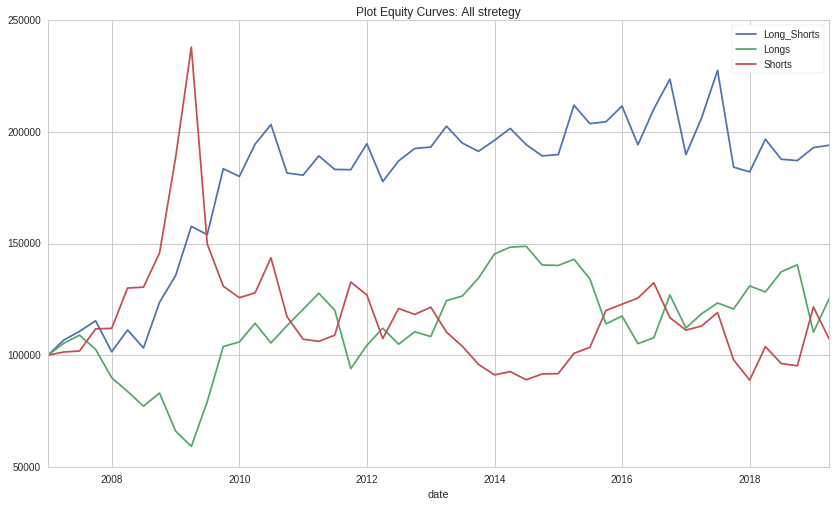

In [32]:
equity_chart()

In [33]:
profit_table

,Long_Shorts,Longs,Shorts
date,,,
2007-01-01,100000.000000,100000.000000,100000.000000
2007-04-01,106758.410000,105339.400000,101419.010000
2007-07-01,110706.192227,108973.066818,101877.873000
2007-10-01,115413.292227,102628.580000,111788.896000
2008-01-01,101553.280477,89901.737205,112016.221305
2008-04-01,111282.000477,83735.450000,130103.422609
2008-07-01,103236.067477,77184.780000,130484.903218
2008-10-01,123717.311665,83020.085632,145792.140437
2009-01-01,135682.175665,66013.790000,188603.962873


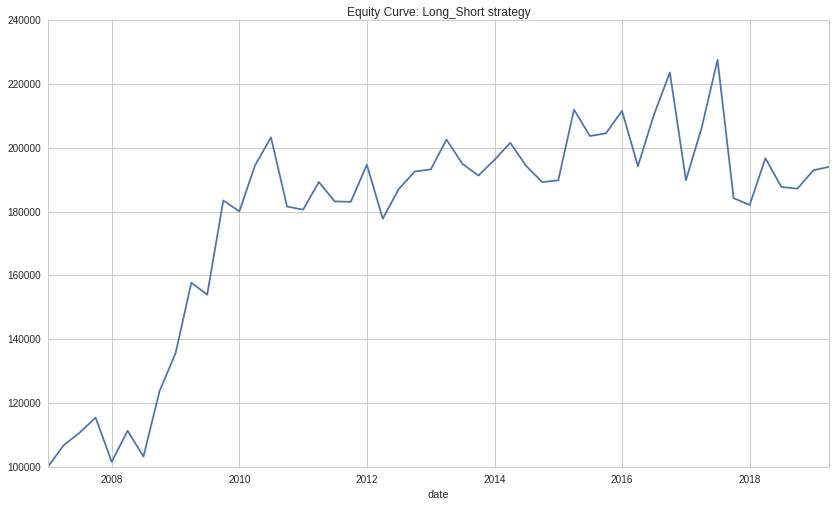

In [34]:
profit_table["Long_Shorts"].plot(title = "Equity Curve: Long_Short strategy");

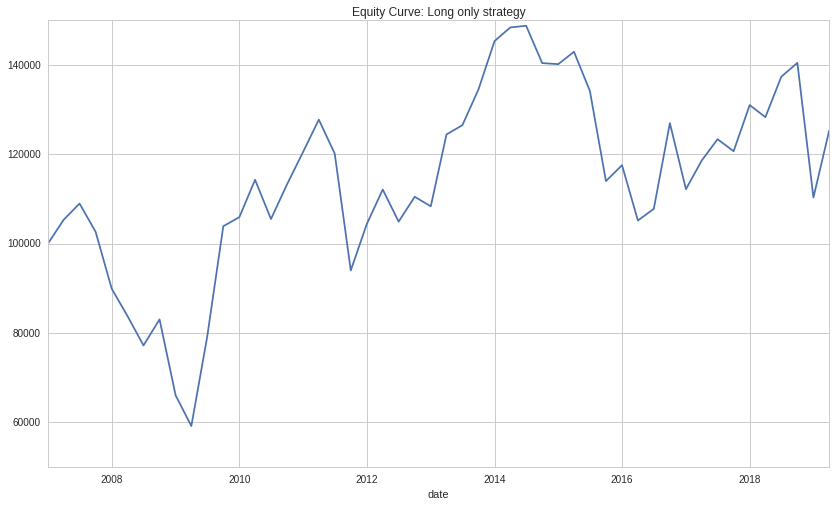

In [35]:
profit_table["Longs"].plot(title = "Equity Curve: Long only strategy");

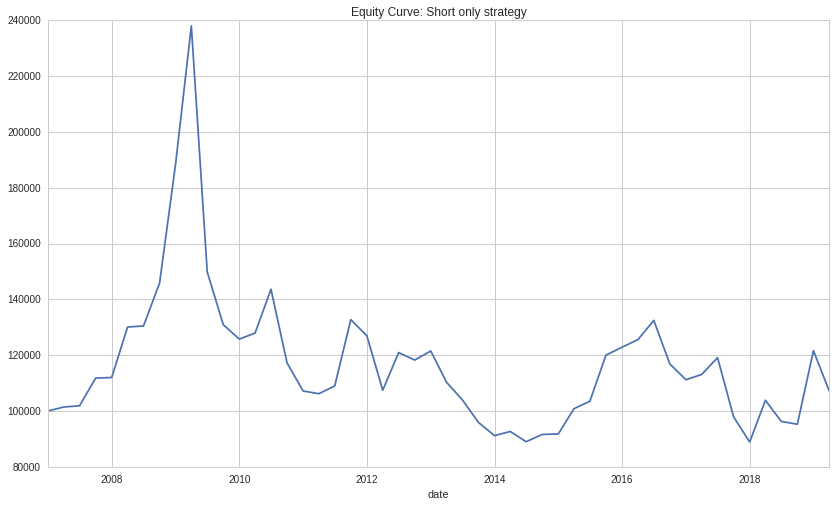

In [36]:
profit_table["Shorts"].plot(title ="Equity Curve: Short only strategy");

# Lists to control and monitor trading activity

In [ ]:
long_short_assets_buys

In [ ]:
long_short_assets_sells

In [ ]:
long_assets[1]

In [ ]:
short_assets[0]